In [1]:
# Reading a Text Log and Converting to CSV with appended labels
# Rule Authoring - Labeling Data for applying Supervised ML Algos

import re
import sys
import netaddr

# Source Access Log file - Text Format
log_file = "E:/Python/Thesis/AIML/Logs_Text/access-2018-12-15.log"

# Destination CSV file with labels
dest_file = "E:/Python/Thesis/AIML/Logs_CSV_Labelled/access-2018-12-15.csv"


# Retrieving data form a a http log file (access_log)
def extract_data(log_file):
    regex = '([(\d\.)]+) - - \[(.*?)\] "(.*?)" (\d+) (.+) "(.*?)" "(.*?)"'
    data = {}

    log_file = open(log_file, 'r')

    for log_line in log_file:
        log_line=log_line.replace(',','_')
        
        log_line = re.match(regex,log_line).groups()
        
        size = str(log_line[4]).rstrip('\n')

        # converting IP to numeric equivalent value
        ip_addr = log_line[0]        
        ip = netaddr.IPAddress(ip_addr)        
        ip_addr_num = ip.value
        
        data_size = int(size)
        
        return_code = log_line[3]

        url = log_line[2]

        param_number = len(url.split('&'))

        url_length = len(url)

        if '-' in size:
            data_size = 0
        else:
            data_size = int(size)

        if (int(return_code) > 0):
            charcs = {}
            charcs['ip_addr'] = ip_addr
            charcs['ip_addr_num'] = ip_addr_num
            charcs['data_size'] = int(data_size)
            charcs['param_number'] = int(param_number)
            charcs['length'] = int(url_length)
            charcs['return_code'] = int(return_code)
            data[url] = charcs        
    return data


# Label data by adding a new column with two possible values:
# label as 1 for Injection Attack or Anomaly and 0 for Normal Web request

def label_data(data,labeled_data):
    
   
    for w in data:

                
        attack = '0'
        attack_label = 'No'

        # Pattrns for identifying Injections - Can add more patterns
        patterns = ['honeypot', '%3b', 'xss', 'sql', '%3c', '%3e', 'eval', 'select', '1=1', 'update', 'union', 'delete']

        # Black Listed example IP addresses - Can add more        
                
        black_ips = ['222.186.20.115', '127.0.0.1']
        
       
        if any(pattern in w.lower() for pattern in patterns):
            print "Injection pattern identified"
            attack = '1'
            attack_label = 'Yes'

        if any(blackip in (data[w]['ip_addr']) for blackip in black_ips):
            print "Black IP Address Matched in Log File"
            attack = '1'
            attack_label = 'Yes'
        
        # Set limit for maximum Bytes of data for web response - Exceeding means suspicious - Possibly Injection    
        
        if data[w]['data_size'] > 1000000 :
            print "Request Served Having more than 1000000 Bytes of data than set limit"
            attack = '1'
            attack_label = 'Yes'

        data_row = str(data[w]['ip_addr'])+ ',' + str(data[w]['ip_addr_num'])+ ',' + str(data[w]['data_size']) + ',' + str(data[w]['length']) + ',' + str(data[w]['param_number']) + ',' + str(data[w]['return_code']) + ',' + attack + ','+ attack_label + ',' + w + '\n'

        labeled_data.write(data_row)
    print str(len(data)) + ' rows have successfully saved with labels to ' + dest_file
    
    

label_data(extract_data(log_file),open(dest_file, 'w'))


Injection pattern identified
Injection pattern identified
Request Served Having more than 1000000 Bytes of data than set limit
Injection pattern identified
Injection pattern identified
Request Served Having more than 1000000 Bytes of data than set limit
Request Served Having more than 1000000 Bytes of data than set limit
Request Served Having more than 1000000 Bytes of data than set limit
Request Served Having more than 1000000 Bytes of data than set limit
Injection pattern identified
Black IP Address Matched in Log File
Injection pattern identified
Request Served Having more than 1000000 Bytes of data than set limit
Request Served Having more than 1000000 Bytes of data than set limit
Request Served Having more than 1000000 Bytes of data than set limit
Injection pattern identified
Request Served Having more than 1000000 Bytes of data than set limit
Injection pattern identified
Black IP Address Matched in Log File
3809 rows have successfully saved with labels to E:/Python/Thesis/AIML/Lo

In [1]:
# Looking for Sample Records after Conversion

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
logs1  = pd.read_csv("E:/Python/Thesis/AIML/Logs_CSV_Labelled/access-2018-12-17.csv", names=['ip', 'ip_num', 'data_size','url_len', 'parameters_no','return_code','attack','attack_label','url_req'])
logs1.head()

,ip,ip_num,data_size,url_len,parameters_no,return_code,attack,attack_label,url_req
0,54.36.148.98,908366946,284,47,1,404,0,No,GET /self.logs/error.log.2015-10-28.gz HTTP/1.1
1,77.75.78.162,1296780962,51421,48,1,200,0,No,GET /self.logs/access.log.2017-11-07.gz HTTP/1.1
2,66.249.75.2,1123633922,339,32,1,404,0,No,GET /hsrdiqmpmzcbb.html HTTP/1.1
3,54.36.148.151,908366999,284,47,1,404,0,No,GET /self.logs/error.log.2015-09-06.gz HTTP/1.1
4,207.46.13.152,3475901848,13808,32,1,200,0,No,GET /self.logs/?C=D;O=A HTTP/1.1


In [13]:
# create a mapping from logs label value for making results easier to interpret
lookup_logs_type = dict(zip(logs1.attack.unique(), logs1.attack_label.unique()))   
lookup_logs_type

{0: 'No', 1: 'Yes'}

In [2]:
# Parameters Setting & Accuracy Score demo using Train Test Split for Supervised ML Algos
from sklearn.neighbors import KNeighborsClassifier

X = logs1[['ip_num', 'data_size', 'url_len', 'parameters_no', 'return_code']]
y = logs1['attack_label']


# Trian Test Split - Default split is 75% for train and 25% for test 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


# KNN  Algo
# algorithm : {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}

print "\n\n=-=-=-=-=-=- KNN Classifier -=-=-=-=-=-=-\n"

knn = KNeighborsClassifier(n_neighbors=3, metric = 'minkowski', p=2, weights='uniform', algorithm='ball_tree', leaf_size=30)
print knn.fit(X_train, y_train)
print 'KNN Accuracy Score =>' 
print knn.score(X_test, y_test)



=-=-=-=-=-=- KNN Classifier -=-=-=-=-=-=-

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')
KNN Accuracy Score =>
0.959595959596


<IPython.core.display.Javascript object>


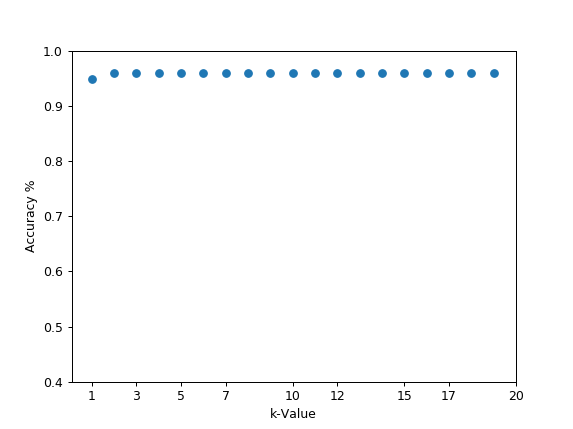

([<matplotlib.axis.YTick at 0xa4ef830>,
 <a list of 7 Text yticklabel objects>)

In [3]:
# Accuracy Plot for Different Values of K in KNN
k_range = range(1,20)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k, metric = 'minkowski', p=2, weights='uniform', algorithm='ball_tree', leaf_size=30)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))

plt.figure()
plt.xlabel('k-Value')
plt.ylabel('Accuracy %')
plt.scatter(k_range, scores)
plt.xticks([1,3,5,7,10,12, 15,17,20]);
plt.yticks([0.40,0.50,0.60,0.70,0.80,0.90,1])

<IPython.core.display.Javascript object>


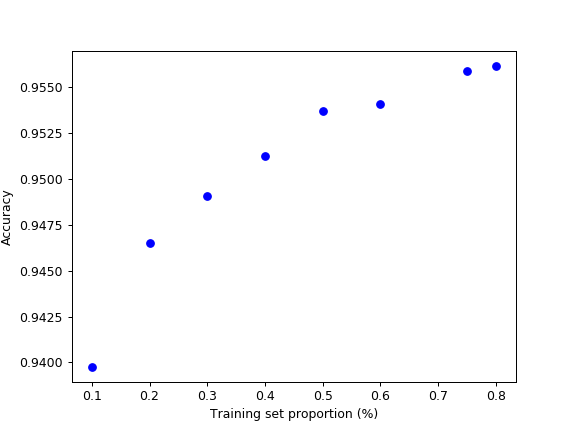

In [4]:
t = [0.8, 0.75, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

knn = KNeighborsClassifier(n_neighbors=1, weights='uniform', algorithm='ball_tree', leaf_size=30)

plt.figure()

for s in t:

    scores = []
    for i in range(1,1000):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-s)
        knn.fit(X_train, y_train)
        scores.append(knn.score(X_test, y_test))
    plt.plot(s, np.mean(scores), 'bo')

plt.xlabel('Training set proportion (%)')
plt.ylabel('Accuracy');

In [15]:
# Supervised Learning - Train and Predict on Next Day Un-seen Log File
# Demo of supervised  KNN Algo to predict intrusion/suspecious activities in http logs

traning_data = "E:/Python/Thesis/AIML/Logs_CSV_Labelled/access-2018-12-15.csv"
testing_data = "E:/Python/Thesis/AIML/Logs_CSV_Labelled/access-2018-12-16.csv"


def get_data_details(csv_data):
        data = np.genfromtxt(csv_data, delimiter = ",")
                
        features = data[:, [1,2,3,4,5]]
        labels = data[:, 6]        
        
        return features, labels

def get_occuracy(real_labels, predicted_labels, fltr):
        real_label_count = 0.0
        predicted_label_count = 0.0

        for real_label in real_labels:
                if real_label == fltr:
                        real_label_count += 1

        for predicted_label in predicted_labels:
                if predicted_label == fltr:
                        predicted_label_count += 1

        print "Real number of attacks: " + str(real_label_count)
        print "Predicted number of attacks: " + str(predicted_label_count)

        precision = predicted_label_count * 100 / real_label_count
        return precision

# Get training features and labeles
training_features, traning_labels = get_data_details(traning_data)

# Get testing features and labels
testing_features, testing_labels = get_data_details(testing_data)


# 1-KNN  Algo
print "\n\n=-=-=-=-=-=-=- KNN Classifier -=-=-=-=-=-=-=-\n"

# Instanciate the classifier
attack_classifier = KNeighborsClassifier(n_neighbors=1, weights='uniform', algorithm='ball_tree', leaf_size=30)
# Train the classifier
attack_classifier = attack_classifier.fit(training_features, traning_labels)
# Get predections for the testing data
predictions = attack_classifier.predict(testing_features)
print "The precision of the KNN Classifier is: " + str(get_occuracy(testing_labels,predictions, 1)) + "%"



=-=-=-=-=-=-=- KNN Classifier -=-=-=-=-=-=-=-

Real number of attacks: 33.0
Predicted number of attacks: 11.0
The precision of the KNN Classifier is: 33.3333333333%


In [18]:
# 2-DECISON TREE Algo Implementation

#from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
from sklearn import tree
from sklearn.model_selection import train_test_split

logs1  = pd.read_csv("E:/Python/Thesis/AIML/Logs_CSV_Labelled/access-2019-05-15.csv", names=['ip', 'ip_num', 'data_size','url_len', 'parameters_no','return_code','attack','attack_label','url_req'])
#logs1.head()

X = logs1[['ip_num', 'data_size', 'url_len', 'parameters_no', 'return_code']]
y = logs1['attack_label']

# Trian Test Split - Default split is 75% for train and 25% for test 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# 2-DECISON TREE Algo
print "\n\n=-=-=-=-=-=- Decision Tree Classifier -=-=-=-=-=-=-\n"

#dt = tree.DecisionTreeClassifier()
dt = tree.DecisionTreeClassifier(criterion = 'gini', max_depth=7, max_features='auto')

print dt.fit(X_train, y_train)
print 'Decision Tree Accuracy Score =>' 
print dt.score(X_test, y_test)



=-=-=-=-=-=- Decision Tree Classifier -=-=-=-=-=-=-

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Decision Tree Accuracy Score =>
0.970149253731


In [19]:
# Supervised Learning - Train and Predict on Next Day Un-seen Log File
# Demo of Decision Tree Algo to predict intrusion/suspecious activities in http logs

import numpy as np
traning_data = "E:/Python/Thesis/AIML/Logs_CSV_Labelled/access-2018-12-15.csv"
testing_data = "E:/Python/Thesis/AIML/Logs_CSV_Labelled/access-2018-12-16.csv"


def get_data_details(csv_data):
        data = np.genfromtxt(csv_data, delimiter = ",")
                
        features = data[:, [1,2,3,4,5]]
        labels = data[:, 6]        
        
        return features, labels

def get_occuracy(real_labels, predicted_labels, fltr):
        real_label_count = 0.0
        predicted_label_count = 0.0

        for real_label in real_labels:
                if real_label == fltr:
                        real_label_count += 1

        for predicted_label in predicted_labels:
                if predicted_label == fltr:
                        predicted_label_count += 1

        print "Real number of attacks: " + str(real_label_count)
        print "Predicted number of attacks: " + str(predicted_label_count)

        precision = predicted_label_count * 100 / real_label_count
        return precision

# Get training features and labeles
training_features, traning_labels = get_data_details(traning_data)

# Get testing features and labels
testing_features, testing_labels = get_data_details(testing_data)


# 2-DECISON TREE Algo
print "\n\n=-=-=-=-=-=- Decision Tree Classifier -=-=-=-=-=-=-=-=\n"

# Instanciate the classifier

attack_classifier1 = tree.DecisionTreeClassifier(criterion = 'gini', max_depth=7, max_features='auto')
#attack_classifier1 = tree.DecisionTreeClassifier()

# Train the classifier
attack_classifier1 = attack_classifier1.fit(training_features, traning_labels)
# Get predections for the testing data
predictions1 = attack_classifier1.predict(testing_features)
print "The precision of the Decision Tree Classifier is: " + str(get_occuracy(testing_labels,predictions1, 1)) + "%"



=-=-=-=-=-=- Decision Tree Classifier -=-=-=-=-=-=-=-=

Real number of attacks: 33.0
Predicted number of attacks: 16.0
The precision of the Decision Tree Classifier is: 48.4848484848%


In [21]:
# Parameters Setting & Accuracy Score demo using Train Test Split for Supervised ML Algos
from sklearn.neighbors import KNeighborsClassifier

X = logs1[['ip_num', 'data_size', 'url_len', 'parameters_no', 'return_code']]
y = logs1['attack_label']


# Trian Test Split - Default split is 75% for train and 25% for test 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


# KNN  Algo
print "\n\n=-=-=-=-=-=- KNN Classifier -=-=-=-=-=-=-\n"
knn = KNeighborsClassifier(n_neighbors = 3)
print knn.fit(X_train, y_train)
print 'KNN Accuracy Score =>' 
print knn.score(X_test, y_test)


# 2-DECISON TREE Algo
print "\n\n=-=-=-=-=-=- Decision Tree Classifier -=-=-=-=-=-=-\n"
dt = tree.DecisionTreeClassifier()
print dt.fit(X_train, y_train)
print 'Decision Tree Accuracy Score =>' 
print dt.score(X_test, y_test)





=-=-=-=-=-=- KNN Classifier -=-=-=-=-=-=-

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')
KNN Accuracy Score =>
0.94776119403


=-=-=-=-=-=- Decision Tree Classifier -=-=-=-=-=-=-

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Decision Tree Accuracy Score =>
0.955223880597


In [22]:
import sys
import numpy as np
from sklearn import tree, linear_model, svm


def get_data_details(csv_data):
        data = np.genfromtxt(csv_data, delimiter = ",")
                
        features = data[:, [1,2,3,4,5]]
        labels = data[:, 6]
        
        
        return features, labels

def get_occuracy(real_labels, predicted_labels, fltr):
        real_label_count = 0.0
        predicted_label_count = 0.0

        for real_label in real_labels:
                if real_label == fltr:
                        real_label_count += 1

        for predicted_label in predicted_labels:
                if predicted_label == fltr:
                        predicted_label_count += 1

        print "Real number of attacks: " + str(real_label_count)
        print "Predicted number of attacks: " + str(predicted_label_count)

        precision = predicted_label_count * 100 / real_label_count
        return precision
print "Done This"

Done This


In [23]:
# Supervised Learning - Train and Predict on Next Days Unseen File
# Demo of supervised  ML Algos to predict intrusion/suspecious activities in http logs


traning_data = "E:/Python/Thesis/AIML/Logs_CSV_Labelled/access-2018-12-15.csv"
testing_data = "E:/Python/Thesis/AIML/Logs_CSV_Labelled/access-2018-12-16.csv"


# Get training features and labeles
training_features, traning_labels = get_data_details(traning_data)

# Get testing features and labels
testing_features, testing_labels = get_data_details(testing_data)


# 1-KNN  Algo
print "\n\n=-=-=-=-=-=-=- KNN Classifier -=-=-=-=-=-=-=-\n"

# Instanciate the classifier
attack_classifier = KNeighborsClassifier(n_neighbors=3)
# Train the classifier
attack_classifier = attack_classifier.fit(training_features, traning_labels)
# Get predections for the testing data
predictions = attack_classifier.predict(testing_features)
print "The precision of the KNN Classifier is: " + str(get_occuracy(testing_labels,predictions, 1)) + "%"


# 2-DECISON TREE Algo
print "\n\n=-=-=-=-=-=- Decision Tree Classifier -=-=-=-=-=-=-\n"

# Instanciate the classifier
attack_classifier1 = tree.DecisionTreeClassifier()
# Train the classifier
attack_classifier1 = attack_classifier1.fit(training_features, traning_labels)
# Get predections for the testing data
predictions1 = attack_classifier1.predict(testing_features)
print "The precision of the Decision Tree Classifier is: " + str(get_occuracy(testing_labels,predictions1, 1)) + "%"


# 3-LOGISTIC REGRESSION Algo
print "\n\n=-=-=-=-=-=-=- Logistic Regression Classifier -=-=-=-=-=-\n"

# Instanciate the classifier
attack_classifier2 = linear_model.LogisticRegression(C = 100, solver='lbfgs')
# Train the classifier
attack_classifier2.fit(training_features, traning_labels)
# Get predections for the testing data
predictions2 = attack_classifier2.predict(testing_features)
print "The precision of the Logistic Regression Classifier is: " + str(get_occuracy(testing_labels,predictions2, 1)) + "%"








=-=-=-=-=-=-=- KNN Classifier -=-=-=-=-=-=-=-

Real number of attacks: 33.0
Predicted number of attacks: 9.0
The precision of the KNN Classifier is: 27.2727272727%


=-=-=-=-=-=- Decision Tree Classifier -=-=-=-=-=-=-

Real number of attacks: 33.0
Predicted number of attacks: 16.0
The precision of the Decision Tree Classifier is: 48.4848484848%


=-=-=-=-=-=-=- Logistic Regression Classifier -=-=-=-=-=-

Real number of attacks: 33.0
Predicted number of attacks: 10.0
The precision of the Logistic Regression Classifier is: 30.303030303%


In [24]:
# 4-SVM CLASSIFIER Algo
# Very slow on large numeric values - features reduced

def get_data_SVM(csv_data):
        data = np.genfromtxt(csv_data, delimiter = ",")               
        features = data[:, [3,4,5]]
        labels = data[:, 6]    
        
        return features, labels
    
# Get training features and labeles
training_features, traning_labels = get_data_SVM(traning_data)

# Get testing features and labels
testing_features, testing_labels = get_data_SVM(testing_data)

print "\n\n=-=-=-=-=-=-=- SVM Classifier -=-=-=-=-=-\n"
# Instanciate the classifier
attack_classifier3 = svm.SVC(kernel='linear') # Linear Kernel
# Train the classifier
attack_classifier3.fit(training_features, traning_labels)
# Get predections for the testing data
predictions3 = attack_classifier3.predict(testing_features)
print "The precision of the SVM Classifier is: " + str(get_occuracy(testing_labels,predictions3, 1)) + "%"



=-=-=-=-=-=-=- SVM Classifier -=-=-=-=-=-

Real number of attacks: 33.0
Predicted number of attacks: 6.0
The precision of the SVM Classifier is: 18.1818181818%


<IPython.core.display.Javascript object>


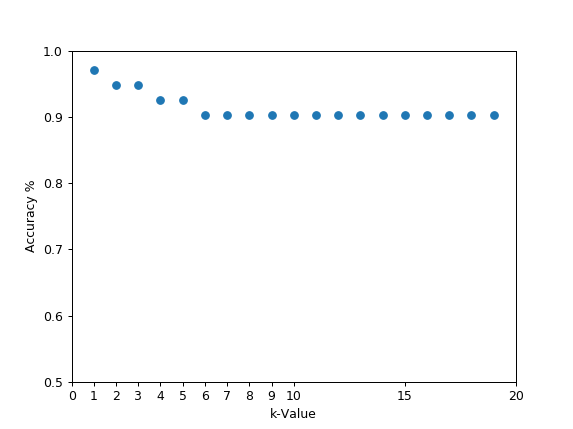

([<matplotlib.axis.YTick at 0xa9343f0>,
 <a list of 6 Text yticklabel objects>)

In [25]:
# Accuracy Plot for Different Values of K in KNN
k_range = range(1,20)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))

plt.figure()
plt.xlabel('k-Value')
plt.ylabel('Accuracy %')
plt.scatter(k_range, scores)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,15,20]);
plt.yticks([0.5,0.6,0.7,0.8,0.9,1])